<a href="https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/main/notebooks/notebook_train_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧙‍♂️ Training diffusion model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebooks/notebook_train_flow.ipynb)

### Initial setup ⚙️

In [55]:
!git fetch https://github.com/Jac-Zac/PML_DL_Final_Project.git

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 16.13 KiB | 2.30 MiB/s, done.
From https://github.com/Jac-Zac/PML_DL_Final_Project
 * branch            HEAD       -> FETCH_HEAD


In [2]:
import os

repo_dir = "PML_DL_Final_Project"

if not os.path.exists(repo_dir):
    !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
else:
    print(f"Repository '{repo_dir}' already exists. Skipping clone.")

Cloning into 'PML_DL_Final_Project'...
remote: Enumerating objects: 488, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 488 (delta 130), reused 135 (delta 67), pack-reused 270 (from 1)
Receiving objects: 100% (488/488), 449.85 KiB | 13.63 MiB/s, done.
Resolving deltas: 100% (274/274), done.


In [3]:
if os.path.isdir(repo_dir):
    %cd $repo_dir
    !pip install dotenv -q
else:
    print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

/content/PML_DL_Final_Project


### 📦 Imports

In [73]:
import torch
import numpy as np

from src.train.train import train
from src.utils.data import get_dataloaders
# from src.utils.plots import plot_image_grid
from src.utils.environment import get_device, set_seed, load_pretrained_model

# train
from typing import Optional

import torch
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

from src.utils.environment import load_checkpoint
from src.utils.wandb import (
    initialize_wandb,
    log_epoch_metrics,
    log_sample_grid,
    log_training_step,
    save_best_model_artifact,
)

import src.utils.wandb


# Since on a notebook we can have nicer bars
from tqdm.notebook import tqdm as tqdm_notebook

## Flow Matching implementation

In [100]:
from typing import Optional

import torch
from torch import Tensor, nn


class FlowMatching:
    def __init__(self, img_size: int = 64, device: torch.device = torch.device("cpu")):
        self.img_size = img_size
        self.device = device

    def _sample_timesteps(self, batch_size: int) -> Tensor:
        return torch.rand(batch_size, device=self.device)

    def perform_training_step(
        self,
        model: nn.Module,
        x0: Tensor,  # noise ~ N(0,I)
        x1: Tensor,  # data in [-1,1]
        y: Optional[Tensor] = None,
    ) -> Tensor:
        B = x0.size(0)
        t = self._sample_timesteps(B)
        t4 = t.view(-1, 1, 1, 1)  # shape: [B, 1, 1, 1]
        x_t = (1 - t4) * x0 + t4 * x1  # linear OT path

        # True velocity & normalization
        dx = x1 - x0

        u_t = model(x_t, t, y=y)
        assert u_t.shape == dx.shape

        # Time-weighted MSE loss
        return ((u_t - dx).pow(2)).mean()

    @torch.no_grad()
    # def sample(
    #     self,
    #     model: nn.Module,
    #     x_init: Optional[Tensor] = None,
    #     steps: int = 100,
    #     y: Optional[Tensor] = None,
    #     log_intermediate: bool = False,
    #     t_sample_skip = 1,
    #     t_sample_times: Optional[list[int]] = None,
    # ) -> list[Tensor]:
    #     model.eval()
    #     B = (
    #         y.shape[0]
    #         if y is not None
    #         else (x_init.shape[0] if x_init is not None else 1)
    #     )
    #     C = x_init.shape[1] if x_init is not None else 1
    #     x_t = (
    #         x_init.to(self.device)
    #         if x_init is not None
    #         else torch.randn(B, C, self.img_size, self.img_size, device=self.device)
    #     )

    #     results = []
    #     dt = 1.0 / steps
    #     for i in range(steps):
    #         t = torch.full((B,), i / steps, device=self.device)
    #         u_t = model(x_t, t, y=y)
    #         x_t = x_t + u_t * dt
    #         if t_sample_times and i in t_sample_times:
    #             results.append(self.transform_sampled_image(x_t.clone()))
    #         elif i % t_sample_skip == 0:
    #             results.append(self.transform_sampled_image(x_t.clone()))

    #     results.append(self.transform_sampled_image(x_t))
    #     return results

    def sample(
      self,
      model: nn.Module,
      x_init: Optional[Tensor] = None,
      steps: int = 100,
      y: Optional[Tensor] = None,
      log_intermediate: bool = False,
      t_sample_times: Optional[list[int]] = None,
    ) -> list[Tensor]:

      model.eval()
      B = y.shape[0] if y is not None else (x_init.shape[0] if x_init is not None else 1)
      C = x_init.shape[1] if x_init is not None else 1
      x_t = (
          x_init.to(self.device)
          if x_init is not None
          else torch.randn(B, C, self.img_size, self.img_size, device=self.device)
      )

      results = []
      dt = 1.0 / steps

      sample_step_indices = set()
      if log_intermediate and t_sample_times:
          sample_step_indices = set([steps - t for t in t_sample_times])

      for i in range(steps):
          t = torch.full((B,), i / steps, device=self.device)
          v = model(x_t, t, y=y)
          x_t = x_t + v * dt

          if (i + 1) in sample_step_indices:
              results.append(self.transform_sampled_image(x_t.clone()))

      return results

    @staticmethod
    def transform_sampled_image(image: Tensor) -> Tensor:
        return (image.clamp(-1, 1) + 1) / 2


### 🛠️ Configuration Parameters

In [101]:
epochs = 5
batch_size = 128
learning_rate = 2e-3
seed = 1337
checkpoint_path = "checkpoints/last.ckpt"
model_name = "unet"
method = "flow"  # or "flow"

### 🧪 Setup: Seed and Device

In [102]:
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 🧠 Model Training

#### 📥 Data Loading

In [103]:
# Returns DataLoaders that yield (image, timestep, label)
train_loader, val_loader = get_dataloaders(batch_size=batch_size)

#### Training

In [104]:
def train_one_epoch(
    model,
    dataloader,
    optimizer,
    method_instance,
    device,
    use_wandb,
    grad_clip: float = 1.0,
):
    model.train()
    total_loss = 0.0

    for images, labels in tqdm_notebook(dataloader, desc="Training", leave=False):
        images = images.to(device).mul_(2).sub_(1)  # transforms image values from [0,1] → [-1,1]
        y = labels.to(device)
        x0 = torch.randn_like(images)

        optimizer.zero_grad(set_to_none=True)
        loss = method_instance.perform_training_step(model=model, x0=x0, x1=images, y=y)
        loss.backward()

        if grad_clip is not None:
            clip_grad_norm_(model.parameters(), max_norm=grad_clip)

        optimizer.step()

        loss_val = loss.item()
        total_loss += loss_val

        if use_wandb:
            log_training_step(loss_val)

    return total_loss / max(1, len(dataloader))  #average loss per batch for the epoch


def validate(model, val_loader, method_instance, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm_notebook(val_loader, desc="Validating", leave=False):
            images = images.to(device).mul_(2).sub_(1)
            y = labels.to(device)
            x0 = torch.randn_like(images)

            loss = method_instance.perform_training_step(model=model, x0=x0, x1=images, y=y)
            total_loss += loss.item()

    return total_loss / len(val_loader)


def train(
    num_epochs: int,
    device: torch.device,
    dataloader,
    val_loader,
    learning_rate: float = 1e-3,
    use_wandb: bool = False,
    checkpoint_path: Optional[str] = None,
    model_name: str = "unet",
    model_kwargs: Optional[dict] = None,
    method: str = "flow",
):
    model_kwargs = model_kwargs or {}

    # Initialize scheduler ahead of load_checkpoint
    dummy_optimizer = torch.optim.Adam([torch.zeros(1)], lr=learning_rate)
    scheduler = CosineAnnealingLR(dummy_optimizer, T_max=num_epochs, eta_min=1e-5)

    model, optimizer, _, start_epoch, best_val_loss = load_checkpoint(
        model_name=model_name,
        checkpoint_path=checkpoint_path,
        device=device,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": learning_rate},
        model_kwargs=model_kwargs,
        scheduler=scheduler,
    )

    # Re-create scheduler with real optimizer if not loaded
    if not hasattr(scheduler, "optimizer") or scheduler.optimizer is not optimizer:
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

    # Initialize method instance
    if method == "diffusion":
        # method_instance = Diffusion(img_size=28, device=device)
        print("Ti sei scordato di cambiare in flow matching")
    elif method == "flow":
        method_instance = FlowMatching(img_size=28, device=device)
    else:
        raise ValueError(f"Unsupported method: {method}")

    wandb_run = None
    if use_wandb:
        wandb_run = initialize_wandb(
            project="flow-project",
            config={
                "epochs": num_epochs,
                "lr": learning_rate,
                "model": model_name,
                "num_classes": model_kwargs.get("num_classes"),
                "method": method,
            },
        )

    for epoch in range(start_epoch, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        train_loss = train_one_epoch(
            model, dataloader, optimizer, method_instance, device, use_wandb
        )
        val_loss = validate(model, val_loader, method_instance, device)

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        print(
            f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}"
        )

        # Check if this is the best model
        is_best = val_loss < best_val_loss
        if is_best:
            best_val_loss = val_loss

        if use_wandb:
            log_epoch_metrics(epoch, train_loss, val_loss, current_lr)
            log_sample_grid(model, method_instance, num_samples=5, num_timesteps=6)

            # Save best model artifact when we find a new best
            if is_best:
                save_best_model_artifact(
                    model=model,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    epoch=epoch,
                    val_loss=val_loss,
                    train_loss=train_loss,
                )

    if wandb_run:
        wandb_run.finish()

    print(f"\nTraining complete. Best validation loss: {best_val_loss:.4f}")
    return model

In [22]:
# NOTE: Currently assumes 10 classes are hardcoded
num_classes = 10
model_kwargs = {"num_classes": num_classes}


# NOTE: Instead of using train directly you can write here your custom traiing code
# You can take inspiration from train to see how the checkpoints are saved

# NOTE: You can also directly copy all the code from train a cell above this and modify it inside the notebook
# similarly to what was done for the Flow Matching Class

# But if you use it directly you can directly use model you have from the train


In [105]:
flow_model = train(
    num_epochs=epochs,
    device= device,
    dataloader = train_loader,
    val_loader = val_loader,
    use_wandb = True,
    checkpoint_path = checkpoint_path,
    model_kwargs = model_kwargs,
    method = method
)

WandB already initialized with project: PML_DL_Final_Project

Epoch 1/5


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.8983 | Val Loss: 0.6385 | LR: 0.000905
New best model saved! Epoch 1, Val Loss: 0.6385

Epoch 2/5


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.6159 | Val Loss: 0.5870 | LR: 0.000658
New best model saved! Epoch 2, Val Loss: 0.5870

Epoch 3/5


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5694 | Val Loss: 0.5749 | LR: 0.000352
New best model saved! Epoch 3, Val Loss: 0.5749

Epoch 4/5


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5505 | Val Loss: 0.5466 | LR: 0.000105
New best model saved! Epoch 4, Val Loss: 0.5466

Epoch 5/5


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.5395 | Val Loss: 0.5206 | LR: 0.000010
New best model saved! Epoch 5, Val Loss: 0.5206


epoch,▁▃▅▆█
learning_rate,█▆▄▂▁
train/loss_epoch,█▂▂▁▁
train/loss_step,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▅▄▃▁
best_train_loss,0.53948
best_val_epoch,5
best_val_loss,0.52058
best_val_lr,1e-05
epoch,5
learning_rate,1e-05



Training complete. Best validation loss: 0.5206


## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [106]:
n_samples = 5     #number of classes I want to sample
save_dir = "samples"
max_steps = 1000
model_name = "unet"
num_timesteps = 6

ckpt_path = "checkpoints/best_model.pth"  # or use your last checkpoint

In [107]:
def plot_flowmatching_grid(model, flow_matching, n, max_steps, save_dir, device, num_classes):
    """
    Generates samples at intermediate steps and plots a grid where
    rows = samples and columns = timesteps for Flow Matching.

    Args:
        model: The flow matching model.
        flow_matching: The FlowMatching sampling object.
        n (int): Number of samples to generate.
        max_steps (int): Maximum flow steps.
        save_dir (str): Directory to save the output image.
        device: Torch device to run the model on.
        num_classes: Number of classes for label conditioning.
    """
    num_intermediate = 5  # This will give us 6 time points (including start and end)
    intermediate_steps = np.linspace(
        0, max_steps, num_intermediate + 1, dtype=int
    ).tolist()  # Changed to go from 0 to max_steps

    # Generate labels: 0, 1, ..., n-1 modulo num_classes
    y = torch.arange(n) % num_classes
    y = y.to(device)

    # Sample images
    all_samples_grouped = flow_matching.sample(
        model,
        t_sample_times=intermediate_steps,
        log_intermediate=True,
        y=y,
        steps=max_steps,
    )
    print(f"Generated {n} samples with labels {y.tolist()}")
    print(f"Number of sampled time points: {len(all_samples_grouped)}")
    print(f"Requested timesteps: {intermediate_steps}")

    # Convert list of tensors to tensor
    # Each element in all_samples_grouped has shape [B, C, H, W]
    stacked = torch.stack(all_samples_grouped)  # shape: [T, B, C, H, W]
    print(f"Stacked samples shape: {stacked.shape}")

    # Permute dimensions to [B, T, C, H, W]
    permuted = stacked.permute(1, 0, 2, 3, 4)
    print(f"Permuted samples shape: {permuted.shape}")

    # Flatten to [B*T, C, H, W]
    flat_samples = permuted.reshape(-1, *permuted.shape[2:])
    print(f"Flat samples shape: {flat_samples.shape}")

    # Plot
    os.makedirs(save_dir, exist_ok=True)
    out_path = os.path.join(save_dir, "all_samples_grid.png")

    num_samples = n
    num_timesteps = len(all_samples_grouped)  # Use actual number of returned timesteps
    expected_images = num_samples * num_timesteps
    print(f"Expecting {expected_images} images, got {len(flat_samples)}")

    assert len(flat_samples) == expected_images, \
        f"Mismatch in image count. Expected {expected_images}, got {len(flat_samples)}"

    fig, axes = plt.subplots(
        num_samples, num_timesteps,
        figsize=(1.5 * num_timesteps, 1.5 * num_samples)
    )

    if num_samples == 1:
        axes = np.expand_dims(axes, 0)
    if num_timesteps == 1:
        axes = np.expand_dims(axes, 1)

    for row in range(num_samples):
        for col in range(num_timesteps):
            idx = row * num_timesteps + col
            img = flat_samples[idx]
            if isinstance(img, torch.Tensor):
                img = img.squeeze().cpu().numpy()
                if img.ndim == 3:  # If color image, transpose to HWC
                    img = img.transpose(1, 2, 0)

            ax = axes[row, col]
            ax.imshow(img, cmap="gray" if img.ndim == 2 else None)
            ax.axis("off")

            if row == 0:
                # Show actual step number instead of index
                ax.set_title(f"t={intermediate_steps[col]}", fontsize=10)
            if col == 0:
                ax.set_ylabel(f"Sample {row+1}", fontsize=10)

    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight")
    plt.close()

Generated 5 samples with labels [0, 1, 2, 3, 4]
Number of sampled time points: 5
Requested timesteps: [0, 200, 400, 600, 800, 1000]
Stacked samples shape: torch.Size([5, 5, 1, 28, 28])
Permuted samples shape: torch.Size([5, 5, 1, 28, 28])
Flat samples shape: torch.Size([25, 1, 28, 28])
Expecting 25 images, got 25


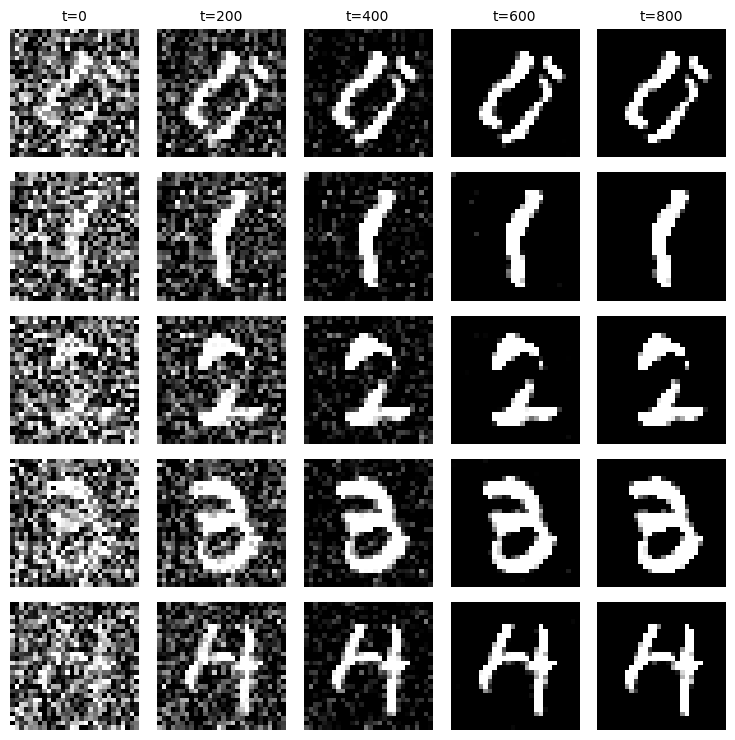

In [108]:
from PIL import Image
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# flow = FlowMatching(img_size=28, device = device)

# 💫 Create diffusion sampler
flow = FlowMatching(img_size=28, device=device)

wandb.init()

log_sample_grid(model= flow_model, method_instance=flow, num_samples=n_samples, num_timesteps=num_timesteps, max_timesteps=max_steps)


plot_flowmatching_grid(
    flow_model,
    flow,
    n=n_samples,
    max_steps=max_steps,
    save_dir=save_dir,
    device=device,
    num_classes=num_classes,
)

out_path = os.path.join(save_dir, "all_samples_grid.png")
display(Image.open(out_path))



# NOTE: Currently assumes 10 classes are hardcoded
#see in to plot_image to make it for flow amtching

# plot_image_grid(
#     model,
#     flow,
#     n=n_samples,
#     max_steps=max_steps,
#     save_dir=save_dir,
#     device=device
#     num_classes=num_classes
# )

# But if you use it directly you can directly use model you have from the train

# model = train(
# num_epochs=epochs,
# device=device,
# dataloader=train_loader,
# val_loader=val_loader,
# learning_rate=learning_rate,
# use_wandb=True,
# checkpoint_path=checkpoint,
# model_name=model_name,
# model_kwargs=model_kwargs,
# method=method,
# )
